In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

import functools
import IPython.display as ipd
import ipywidgets as widgets
import librosa, librosa.display
import multiprocessing
import numpy as np
import os
import pandas as pd
import pywt
import seaborn as sns
import cmocean

sns.set_style('darkgrid')
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
plt.rcParams['figure.dpi'] = 100

In [3]:
train_labels_dataframe = pd.read_csv("FSDKaggle2018.meta/train_post_competition.csv").set_index('fname', drop=True)
test_labels_dataframe = pd.read_csv("FSDKaggle2018.meta/test_post_competition_scoring_clips.csv").set_index('fname', drop=True)

In [4]:
train_labels_dataframe_subset = train_labels_dataframe.sample(200, random_state=2323)
train_labels_dataframe_subset.head()

label  manually_verified  freesound_id             license
fname                                                                        
f8f1f0c3.wav  Tambourine                  0        210639         Attribution
918d0d06.wav   Saxophone                  1         13472  Creative Commons 0
421865a6.wav     Tearing                  0        172628  Creative Commons 0
474d3f52.wav        Gong                  0        365035  Creative Commons 0
da3eb8df.wav       Chime                  0         50402  Creative Commons 0

In [5]:
new_labels_ = sorted(list(zip(train_labels_dataframe_subset.label + ' - ' + train_labels_dataframe_subset.freesound_id.astype(str), train_labels_dataframe_subset.index)))

In [6]:
def plot_a_file(identifier):
    x, sr = librosa.load(f'FSDKaggle2018.audio_train/{identifier}')
    x = librosa.resample(x, sr, target_sr=22050)
    sr = 22050
    
    plt.figure(figsize=(15, 2))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(x, sr=sr, lw=0.1)
    
    ax = plt.subplot(1, 2, 2)
    spec = librosa.feature.melspectrogram(x, sr)
    spec = librosa.amplitude_to_db(spec)

    plt.imshow(spec, origin='lower', cmap=cmocean.cm.dense,  interpolation='none', aspect='auto')
    plt.grid(False)
    plt.tight_layout()
    
    return ipd.Audio(x, rate=sr)

# Raw waveform and MEL spectrogram

In [7]:
interact(plot_a_file, identifier=new_labels_);

interactive(children=(Dropdown(description='identifier', options=(('Acoustic_guitar - 182940', '7bce7d7c.wav')…

# Mel Spectrogram of each waveform

In [8]:
def single_spectrogram(filename, split='train'):
    x, sr = librosa.load(f'FSDKaggle2018.audio_{split}/{filename}')
    if sr != 22050:
        x = librosa.resample(x, sr, target_sr=22050)
        sr = 22050
    spec = librosa.feature.melspectrogram(x, sr)
    spec = librosa.amplitude_to_db(spec)
    return spec.astype(np.float32)

Parallelized mel spectrograms - Google suggests that this is a good view

In [9]:
def make_spectrograms(df, split):
    filenames = df.index.values
    N = filenames.shape[0]
    
    p = multiprocessing.Pool()

    spectrograms = []
    
    f = functools.partial(single_spectrogram, split=split)

    # this could be more efficient, but it's parallel, and good enough
    for z in tqdm_notebook(p.imap(f, filenames), total=N):
        spectrograms.append(z)
        
    df['spec'] = spectrograms
    
    p.close()
    p.join()
    
    del p

In [10]:
!mkdir -p saved

In [11]:
if os.path.isfile('saved/train.pkl'):
    train_labels_dataframe = pd.read_pickle('saved/train.pkl', compression='gzip')
else:
    make_spectrograms(train_labels_dataframe, split='train')
    train_labels_dataframe.to_pickle('saved/train.pkl', compression='gzip')

In [12]:
if os.path.isfile('saved/test.pkl'):
    test_labels_dataframe = pd.read_pickle('saved/test.pkl', compression='gzip')
else:
    make_spectrograms(test_labels_dataframe, split='test')
    test_labels_dataframe.to_pickle('saved/test.pkl', compression='gzip')

# Data is now prepped, let's do quick exploration

In [13]:
train_labels_dataframe.head()

label  manually_verified  freesound_id  \
fname                                                         
00044347.wav        Hi-hat                  0         28739   
001ca53d.wav     Saxophone                  1        358827   
002d256b.wav       Trumpet                  0         10897   
0033e230.wav  Glockenspiel                  1        325017   
00353774.wav         Cello                  1        195688   

                         license  \
fname                              
00044347.wav         Attribution   
001ca53d.wav         Attribution   
002d256b.wav  Creative Commons 0   
0033e230.wav         Attribution   
00353774.wav         Attribution   

                                                           spec  
fname                                                            
00044347.wav  [[-30.069778, -30.069778, -25.07729, -30.06977...  
001ca53d.wav  [[-29.005005, -29.005005, -29.005005, -29.0050...  
002d256b.wav  [[-81.18214, -70.73889, -60.036716, -62.388527...  
0033e230.wav  [[-59.581963, -59.581963, -59.581963, -59.5819...  
00353774.wav  [[-19.382536, -25.907024, -26.570444, -21.3387...

In [14]:
test_labels_dataframe.head()

label    usage  freesound_id             license  \
fname                                                                
00326aa9.wav       Oboe  Private        355125         Attribution   
0038a046.wav  Bass_drum  Private         90621  Creative Commons 0   
007759c4.wav  Saxophone  Private         13406  Creative Commons 0   
008afd93.wav  Saxophone  Private        358962         Attribution   
00ae03f6.wav      Chime  Private         78203         Attribution   

                                                           spec  
fname                                                            
00326aa9.wav  [[-20.541588, -20.541588, -20.541588, -20.5415...  
0038a046.wav  [[18.736116, 34.248943, 38.604492, 43.837322, ...  
007759c4.wav  [[-41.23031, -41.23031, -41.23031, -41.23031, ...  
008afd93.wav  [[-19.7719, -19.7719, -19.7719, -19.7719, -19....  
00ae03f6.wav  [[-38.328648, -38.328648, -38.328648, -38.3286...

In [15]:
train_labels_dataframe = train_labels_dataframe.sort_values('label')

In [16]:
Z = (np.hstack([x.ravel() for x in train_labels_dataframe.spec.values]))

In [17]:
Z.shape

(355094784,)

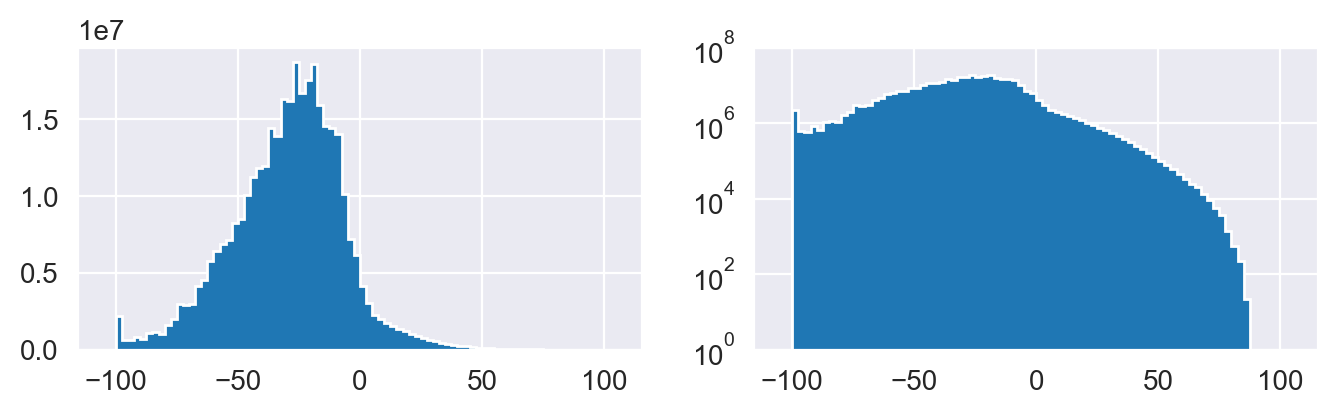

In [18]:
plt.subplot(121)
plt.hist(Z, bins=np.arange(-105, 105.1, 2.5), histtype='stepfilled');
plt.subplot(122)
plt.hist(Z, bins=np.arange(-105, 105.1, 2.5), histtype='stepfilled')
plt.yscale('log')
plt.ylim(1, 1e8)
plt.gcf().set_size_inches(8, 2);

## Rescale images manually based on distributions

In [19]:
# magic constant will put them in the -0.98 to 0.5 range ..
train_labels_dataframe.spec /= 105. 
train_labels_dataframe.spec += 0.262

test_labels_dataframe.spec /= 105. 
test_labels_dataframe.spec += 0.262

In [20]:
Z = (np.hstack([x.ravel() for x in train_labels_dataframe.spec.values]))

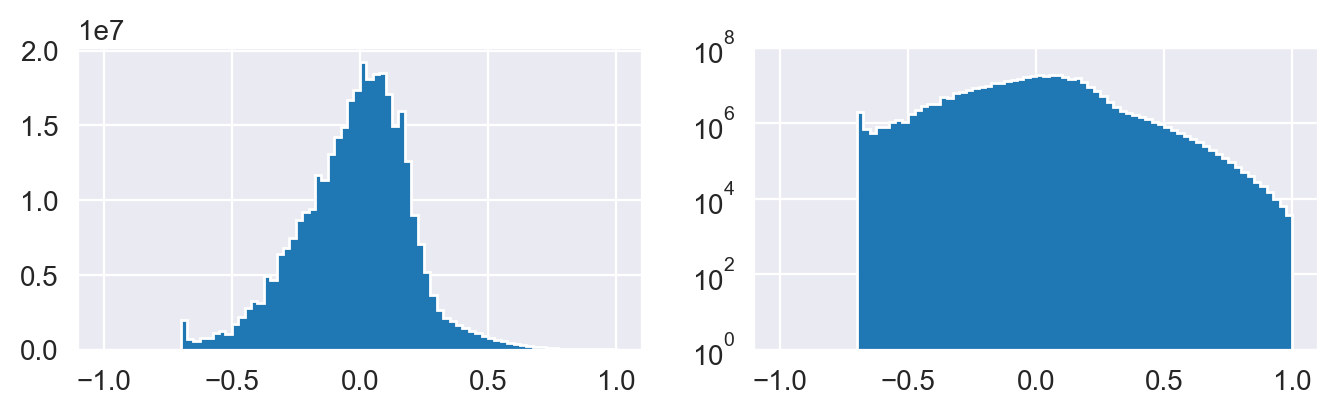

In [21]:
plt.subplot(121)
plt.hist(Z, bins=np.arange(-1.0, 1.01, 0.025), histtype='stepfilled');
plt.subplot(122)
plt.hist(Z, bins=np.arange(-1.0, 1.01, 0.025), histtype='stepfilled')
plt.yscale('log')
plt.ylim(1, 1e8)
plt.gcf().set_size_inches(8, 2);

In [22]:
del Z

# Keras Setup

In [23]:
import sklearn.preprocessing

In [24]:
encoder = sklearn.preprocessing.LabelEncoder()
Y_train = encoder.fit_transform(train_labels_dataframe.label)
Y_test = encoder.transform(test_labels_dataframe.label)

In [25]:
ohe = sklearn.preprocessing.OneHotEncoder()
Y_train_ohe = (ohe.fit_transform(Y_train.reshape(-1, 1))).todense()
Y_test_ohe = (ohe.transform(Y_test.reshape(-1, 1))).todense()

/Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [26]:
train_labels_dataframe.head()

label  manually_verified  freesound_id  \
fname                                                            
3289db4d.wav  Acoustic_guitar                  0          8388   
8dfd2855.wav  Acoustic_guitar                  0        252336   
578874df.wav  Acoustic_guitar                  0          8561   
43a920c9.wav  Acoustic_guitar                  0          8552   
08a68ba1.wav  Acoustic_guitar                  1        183022   

                         license  \
fname                              
3289db4d.wav  Creative Commons 0   
8dfd2855.wav         Attribution   
578874df.wav  Creative Commons 0   
43a920c9.wav  Creative Commons 0   
08a68ba1.wav         Attribution   

                                                           spec  
fname                                                            
3289db4d.wav  [[0.06658286, 0.06658286, 0.06658286, 0.066582...  
8dfd2855.wav  [[0.23057276, 0.259443, 0.23021372, 0.19094685...  
578874df.wav  [[0.06640935, 0.06640935, 0.06640935, 0.210581...  
43a920c9.wav  [[0.11805192, 0.11805192, 0.11805192, 0.256684...  
08a68ba1.wav  [[-0.25314865, -0.3658993, -0.43171903, -0.431...

In [27]:
import keras
from keras import Sequential
from keras import layers as l
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras import metrics

Using TensorFlow backend.
/Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [28]:
X_train = sequence.pad_sequences([x.T for x in train_labels_dataframe.spec.values], maxlen=256, dtype=np.float32, 
                                 padding='post', truncating='post', value=-1.0)
X_test = sequence.pad_sequences([x.T for x in test_labels_dataframe.spec.values], maxlen=256, dtype=np.float32, 
                                 padding='post', truncating='post', value=-1.0)

In [29]:
def make_batches(X, Y, batch_size):
    N = X.shape[0]
    
    rs = np.random.RandomState(np.random.randint(0, 1000000))
    while True:
        idx = rs.randint(0, N, size=batch_size)
        yield X[idx], Y[idx]

In [30]:
X_train.shape, Y_train_ohe.shape

((9473, 256, 128), (9473, 41))

In [31]:
X_test.shape, Y_test_ohe.shape

((1600, 256, 128), (1600, 41))

## Define model, train

In [32]:
model = keras.Sequential()
model.add(l.LSTM(64, return_sequences=True, input_shape=(256, 128)))
model.add(l.LSTM(64, return_sequences=True))
model.add(l.LSTM(64, return_sequences=False))
model.add(l.Dense(64))
model.add(l.Dense(41, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

W0825 15:14:50.859978 4678768064 deprecation_wrapper.py:119] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 15:14:50.890021 4678768064 deprecation_wrapper.py:119] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 15:14:50.892301 4678768064 deprecation_wrapper.py:119] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 15:14:51.495819 4678768064 deprecation_wrapper.py:119] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Pl

In [33]:
model.output_shape

(None, 41)

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 41)                2665      
Total params: 122,281
Trainable params: 122,281
Non-trainable params: 0
_________________________________________________________________


In [35]:
X_test.shape, Y_test_ohe.shape

((1600, 256, 128), (1600, 41))

In [36]:
checkpointer = keras.callbacks.ModelCheckpoint('saved/weights.{epoch:04d}-{val_loss:.3f}.hdf5', monitor='val_loss', verbose=0, 
                                               save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [37]:
model.fit_generator(make_batches(X_train, Y_train_ohe, batch_size=32), 
                    validation_data=(X_test, Y_test_ohe),
                    steps_per_epoch=16, epochs=400,
                    use_multiprocessing=True, workers=4,
                    callbacks=[checkpointer]
                   )

W0825 15:14:51.681615 4678768064 deprecation.py:323] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0825 15:14:53.507876 4678768064 deprecation_wrapper.py:119] From /Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/400


/Users/shekhar/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


16/16 [==============================] - 55s 3s/step - loss: 3.6473 - top_k_categorical_accuracy: 0.2207 - categorical_accuracy: 0.0859 - val_loss: 3.7364 - val_top_k_categorical_accuracy: 0.1619 - val_categorical_accuracy: 0.0338
Epoch 2/400
16/16 [==============================] - 46s 3s/step - loss: 3.6402 - top_k_categorical_accuracy: 0.2520 - categorical_accuracy: 0.0723 - val_loss: 3.7118 - val_top_k_categorical_accuracy: 0.1688 - val_categorical_accuracy: 0.0488
Epoch 3/400
16/16 [==============================] - 46s 3s/step - loss: 3.5602 - top_k_categorical_accuracy: 0.2695 - categorical_accuracy: 0.0859 - val_loss: 3.7237 - val_top_k_categorical_accuracy: 0.1619 - val_categorical_accuracy: 0.0288
Epoch 4/400
16/16 [==============================] - 43s 3s/step - loss: 3.6941 - top_k_categorical_accuracy: 0.1973 - categorical_accuracy: 0.0508 - val_loss: 3.7003 - val_top_k_categorical_accuracy: 0.1450 - val_categorical_accuracy: 0.0450
Epoch 5/400
16/16 [=====================